In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format='retina'

# Contents
 - [Load data](#load-data) 
 - [Score dependance on length](#Score-dependance-on-length) 
 - [Score dependance on mutation position](#Score-dependance-on-mutation-position)
 - [Score distribution by wildtype protein](#Score-distribution-by-wildtype-protein)
 - [Score distribution by mutation type](#Score-distribution-by-mutation-type)
 

## Load data

We should explore the dataset first in order to find which variables have a high predictive power of $\Delta\Delta$ G. First let's load in the data::

In [2]:
df = pd.read_csv("mega_scale_ddg_single_mut_with_seq_no_con.csv")
df.sample(frac=1).head()

,pdbid,score,variant,aa_seq,aa_seq_full,chainid
288320,EHEE-rd2-0487,0.198197,D7C,TETYKYCDKREAEKAAEEFRRRGITVTVEERNGTWVLESK,SAGGSAGGSAGGSAGGSAGGTETYKYCDKREAEKAAEEFRRRGITV...,A
180648,2RU9,-2.628163,L27T,KEPPYVSSLRIEIPADIAANEALKVRTLETEGVKEVLIAEEEHSAY...,SAKEPPYVSSLRIEIPADIAANEALKVRTLETEGVKEVLIAEEEHS...,A
331429,r11-829-TrROS-Hall,0.106982,N9I,MTYRVRIEIADGEVVTIEISADELREKGLTLEELLPPNARIVEVEEVEP,SAGGSAGGSAGMTYRVRIEIADGEVVTIEISADELREKGLTLEELL...,A
79686,1A0N,-1.948974,I28R,VTLFVALYDYEARTEDDLSFHKGEKFQRLNSSEGDWWEARSLTTGE...,SAGGSAGVTLFVALYDYEARTEDDLSFHKGEKFQRLNSSEGDWWEA...,A
164315,2K5P,-0.058814,L63A,MNLTVNGKPSTVDGAESLNVTELLSALKVAQAEYVTVELNGEVLER...,SAGGMNLTVNGKPSTVDGAESLNVTELLSALKVAQAEYVTVELNGE...,A


In [3]:
print("There are",len(df), "data points")

There are 339778 data points


In [4]:
print(len(df["pdbid"].unique()), "unique wildtype proteins")

310 unique wildtype proteins


In [5]:
print("on average,",int(339778/310),"variants per wildtype")

on average, 1096 variants per wildtype


## Score dependance on length

2D histogram of $\Delta\Delta G$ vs protein length is shown below. 

For fair comparison at each length, we’ve normalized each row of the histogram by the max. 

It seems like there is not much correlation with length, only slightly less energy for lower lengths.

In [6]:
# Extract protein lengths 
df["lengths"] = df["aa_seq"].apply(lambda x: len(x))

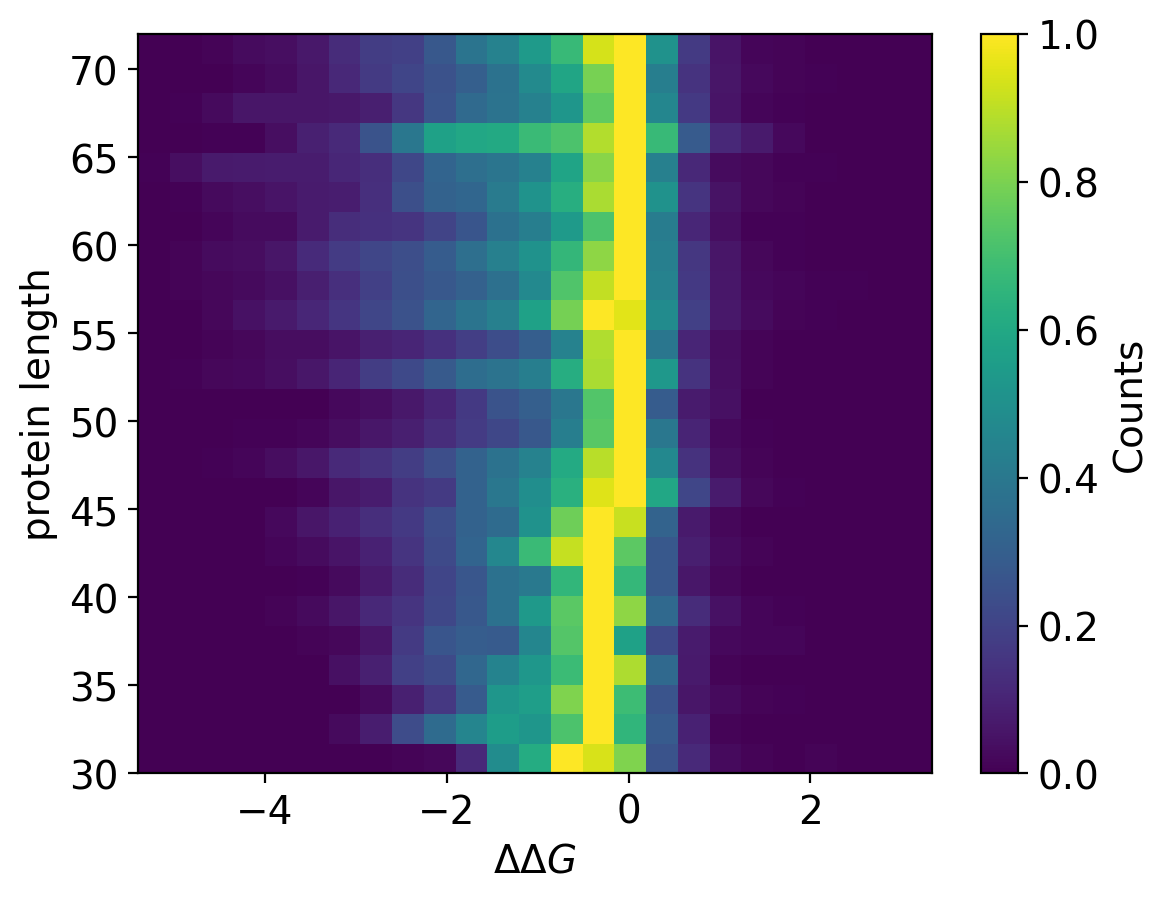

In [7]:
### Plot ddG vs length ###
plt.rcParams.update({'font.size': 14})

# Get histogram of score vs length
hist, xedges, yedges = np.histogram2d(df["score"],df["lengths"], bins=25)
hist = hist[:,:].T

# Normalize each row by the max
hist = hist / hist.max(axis=1, keepdims=True) 

# Plot the histogram
plt.pcolormesh(xedges,yedges,hist)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Counts')  
plt.xlabel("$\Delta\Delta G$")
plt.ylabel("protein length")
plt.savefig("plots/protein_lengths",bbox_inches='tight',facecolor='white', transparent=False,dpi=150)
plt.show()

## Score dependance on mutation position

2D histogram of $\Delta\Delta G$ vs mutation position (as a fractionof the protein length) is shown below

For fair comparison at each position, we’ve normalized each row of the histogram by the max. 

There’s not much correlation with mutation position either, except at the ends of the protein which have mostly no change in $\Delta \Delta G$, presumably because there are less atoms and bonds around the ends of the protein.

In [8]:
# Get fractional mutation position
df["mutation_position"] = df["variant"].apply(lambda x: int(x[1:-1]))
df["mutation_frac_position"] = df["mutation_position"]/df["lengths"]

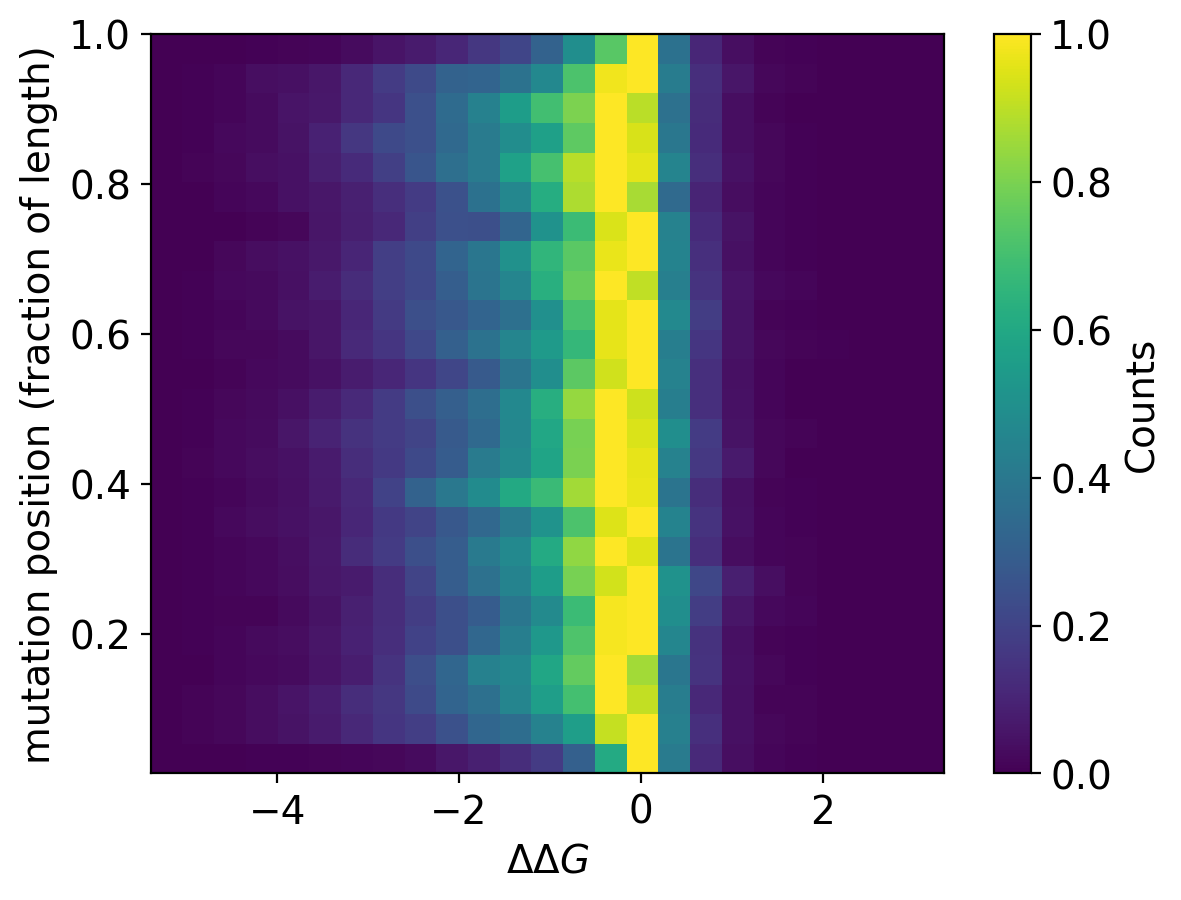

In [9]:
### Plot ddG vs mutation position ###
plt.rcParams.update({'font.size': 14})

# Get histogram of score vs mutation position
hist, xedges, yedges = np.histogram2d(df["score"],df["mutation_frac_position"], bins=25)
hist = hist[:,:].T

# Normalize each row by the max
hist = hist / hist.max(axis=1, keepdims=True)

# Plot the histogram
plt.pcolormesh(xedges,yedges,hist)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Counts')  
plt.xlabel("$\Delta\Delta G$")
plt.ylabel("mutation position (fraction of length)")
plt.savefig("plots/mutation_position",bbox_inches='tight',facecolor='white', transparent=False,dpi=150)
plt.show()

## Score distribution by wildtype protein

$\Delta\Delta G$ histograms are shown for different wildtypes below.

This clearly shows that $\Delta\Delta G$ is dependant on the wildtype which makes sense since it should depend on the structure.

min ddG: -5.392122745053485
max ddG: 3.334218366759023


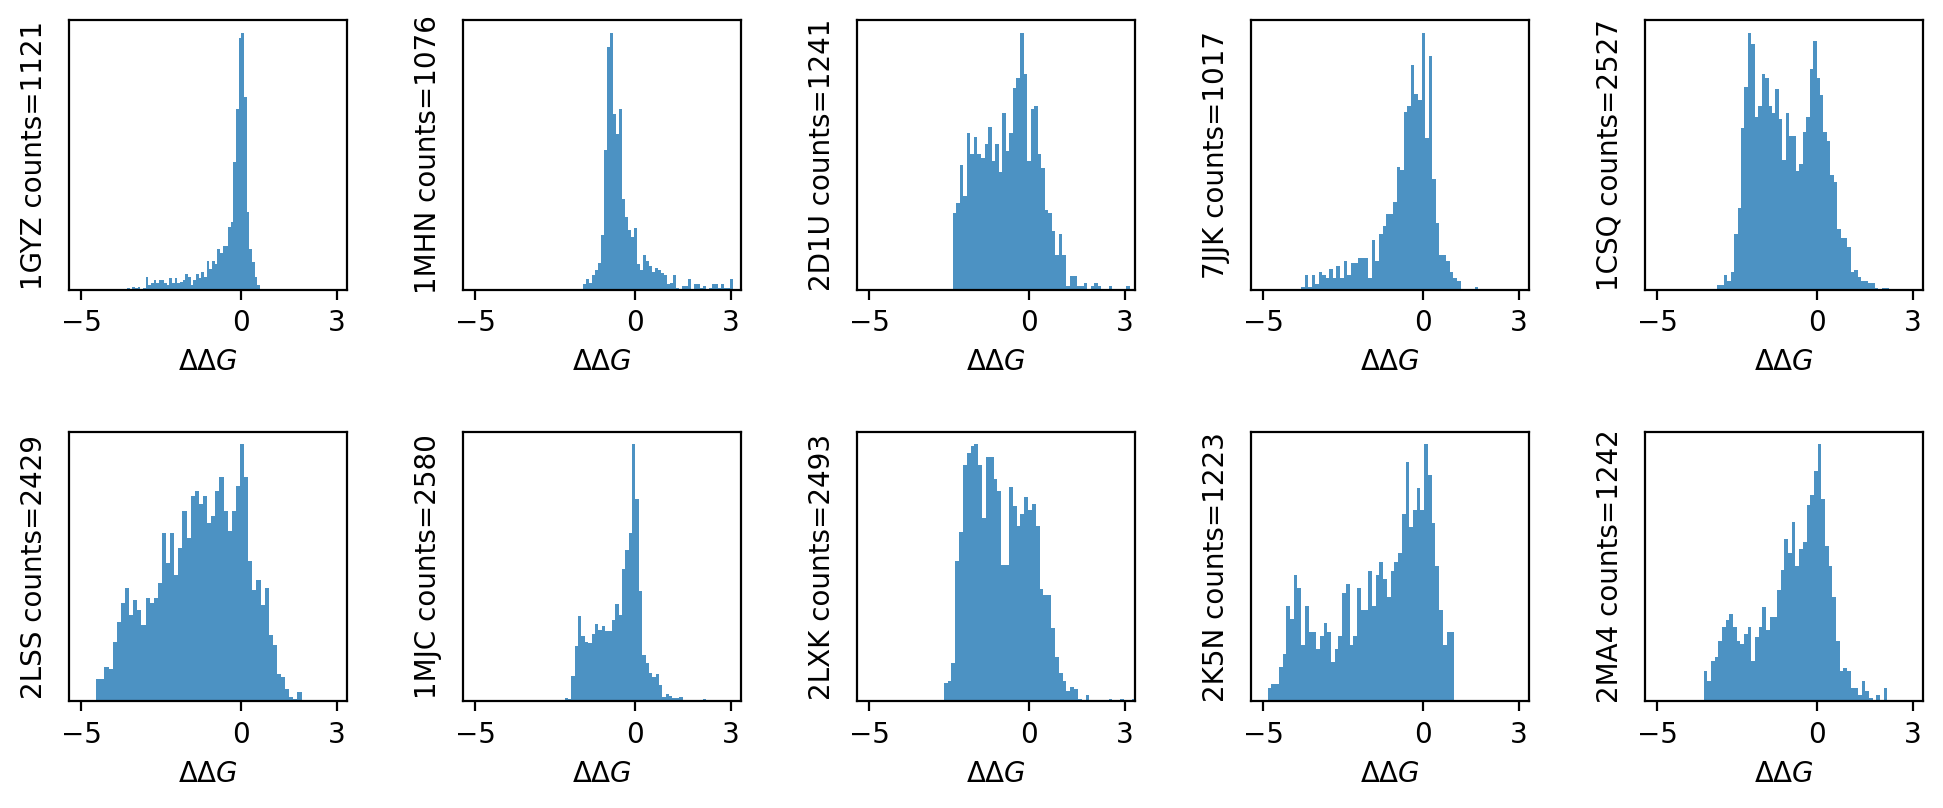

In [10]:
### Plot ddG for difference pdbids ###
plt.rcParams.update({'font.size': 10})

# Get min max ddGs for limits
min_ddg, max_ddg = df["score"].min(),df["score"].max()
print("min ddG:", min_ddg)
print("max ddG:", max_ddg)

# Subplots
fig, ax = plt.subplots(2,5,figsize=(10,4))
plt.tight_layout(h_pad=3)
ax = ax.flatten()

pdbids = df["pdbid"].unique()
for i,wildtype in enumerate(pdbids[:10]):
    # Get df of wildtype
    scores_of_wt = df[df["pdbid"]==wildtype]["score"]

    # Plot histogram
    h = ax[i].hist(scores_of_wt, bins=50, alpha=0.8)
    ax[i].set_xlim(min_ddg,max_ddg)
    ax[i].set_ylabel(f"{wildtype} counts={len(scores_of_wt)}")
    ax[i].set_xlabel("$\Delta\Delta G$")
    ax[i].set_yticks([])
    ax[i].set_xticks([-5,0,3])
plt.savefig("plots/wildtype",bbox_inches='tight',facecolor='white', transparent=False,dpi=150)

## Score distribution by mutation type

$\Delta\Delta G$ histograms are shown for different mutation types  (wildtype amino acid $\rightarrow$ mutant amino acid) below.

The distributions seem to be slightly different for each mutation since the energy should depend on the amino acid substitution.

In [11]:
# Get the before and after amino acids
df["wildtype"] = df["variant"].apply(lambda x: x[0])
df["mutant"] = df["variant"].apply(lambda x: x[-1])
df["aa_change"] = df["wildtype"]+df["mutant"]
df["aa_change"].head()

0    WQ
1    WE
2    WN
3    WH
4    WD
Name: aa_change, dtype: object

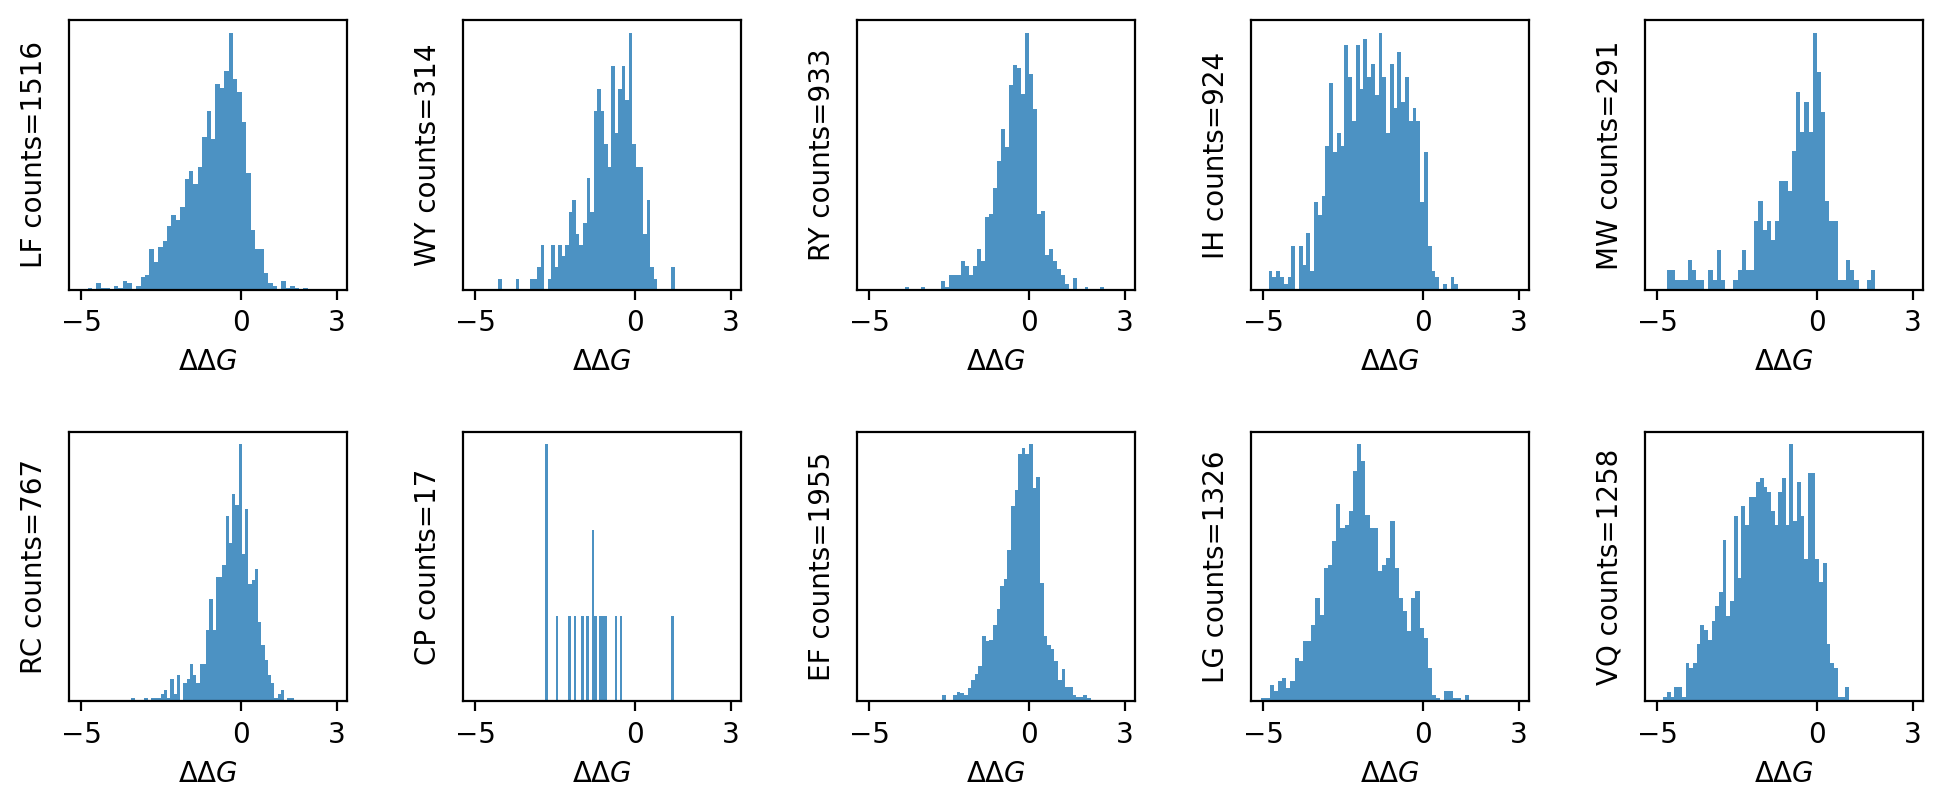

In [12]:
### Plot ddG for different mutations ###
fig, ax = plt.subplots(2,5,figsize=(10,4))
plt.tight_layout(h_pad=3)
ax = ax.flatten()

# Get 10 random mutations and plot
np.random.seed(2)
aa_change = df["aa_change"].unique()
ten_aa_changes = np.random.choice(aa_change,10)
for i,aa in enumerate(ten_aa_changes):
    # Get df of aa change
    scores_of_aa = df[df["aa_change"]==aa]["score"]

    # Plot histogram
    h = ax[i].hist(scores_of_aa, bins=50, alpha=0.8)
    ax[i].set_xlim(min_ddg,max_ddg)
    ax[i].set_ylabel(f"{aa} counts={len(scores_of_aa)}")
    ax[i].set_xlabel("$\Delta\Delta G$")
    ax[i].set_yticks([])
    ax[i].set_xticks([-5,0,3])
    # ax[i].set_title(wildtype, fontsize=10)
plt.savefig("plots/mutation",bbox_inches='tight',facecolor='white', transparent=False,dpi=150)